# Import Packages, Functions, and Data


## Install packages

In [1]:
# Install packages
!pip install atomai --upgrade
!pip install gpim
!wget -qq https://bitbucket.org/piraynal/pydm3reader/get/d06ab6b3aa0f.zip
!pip install pysptools
!git clone https://github.com/pycroscopy/AICrystallographer.git
!cp -r AICrystallographer/AtomNet/* .
!gdown https://drive.google.com/uc?id=1K46kbZoqFV2ao-xPDNN1oDrDSCogqBSp

# Import data files
!git clone https://github.com/nccreang/AE_Workflows.git
!cp -r AE_Workflows/Data/* .
!rm -r AE_Workflows

     |████████████████████████████████| 153kB 5.2MB/s 
     |████████████████████████████████| 194kB 9.5MB/s 
     |████████████████████████████████| 501kB 9.3MB/s 
     |████████████████████████████████| 870kB 15.9MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174981 sha256=7d6a4e5cc538592cbe7782996bdea983f989d7649cbbf5f3cf7585f28d3be86b
  Stored in directory: /root/.cache/pip/wheels/fb/28/5d/95e69a718b35dd00169889b0139a692f6c265d399cab3aa097
Successfully built mendeleev
     |████████████████████████████████| 686kB 8.0MB/s 
     |████████████████████████████████| 8.1MB 5.2MB/s 
  Created wheel for pysptools: filename=pysptools-0.15.0-cp37-none-any.whl size=8133752 sha256=01c3d17f54c22948e426920e87bfff141f461eba2fbb289add2dfda121de943a
  Stored in directory: /root/.cache/pip/wheels/bf/60/be/a6719d91bfa59135201feb034c7069e4146aa576fc0dc9e624
Successfully built pysptools
Cloning into 'AICrystallographer'...
remote: Enumerating objects: 1704, done

##Load packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from copy import deepcopy

import glob
import os
from scipy import ndimage
import pysptools.abundance_maps as amp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gpim
import h5py

import atomai as aoi
from atomai import utils
import torch
import dcnn

##Define functions

In [3]:
def acq(gpmodel, X_full, X_sparse): # leave it as is
  mean, sd = gpmodel.predict(X_full, verbose=0) # leave it as is
  acq = 1 * mean + 4 * sd
  return acq, (mean, sd) # leave it as is


def trial_func(idx):
    """Takes a list of indices as input and returns function value at these indices"""
    return aimg[idx[0], idx[1]]

def get_mask(aimg, points_measured, border_px = 3):
    
    #Get row, col size
    pos_dim_sizes = (aimg.shape[0], aimg.shape[1])
    
    #create mask
    mask = np.full(shape=pos_dim_sizes, fill_value = np.nan)

    #create border
    mask[border_px:-border_px, border_px:-border_px] = 1.0
    
    #Get measured points as (x,y) list
    points_measured_xy = []
    for point in points_measured: 
        points_measured_xy.append(pix_to_xy(point, pos_dim_sizes[-1]))
    
    for (x,y) in points_measured_xy:
        mask[x,y] = np.nan
    
    return mask

def pix_to_xy(pixind, num_cols):
  col = int(pixind % (num_cols))
  row =int(np.floor(pixind/ num_cols))
  return row, col

def xy_to_pixind(row,col,num_cols):
  return row*num_cols + col

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class conv2dblock(nn.Module):
    '''
    Creates a block consisting of convolutional
    layer, leaky relu and (optionally) dropout and
    batch normalization
    '''
    def __init__(self, input_channels, output_channels,
                 kernel_size=3, stride=1, padding=1,
                 use_batchnorm=False, lrelu_a=0.01,
                 dropout_=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            use_batchnorm (boolean): usage of batch normalization
            lrelu_a: value of alpha parameter in leaky/paramteric ReLU activation
            dropout_: value of dropout
        '''
        super(conv2dblock, self).__init__()
        block = []
        block.append(nn.Conv2d(input_channels,
                               output_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding))
        if dropout_ > 0:
            block.append(nn.Dropout(dropout_))
        block.append(nn.LeakyReLU(negative_slope=lrelu_a))
        if use_batchnorm:
            block.append(nn.BatchNorm2d(output_channels))
        self.block = nn.Sequential(*block)

    def forward(self, x):
        '''Forward path'''
        output = self.block(x)
        return output


class upsample_block(nn.Module):
    '''
    Defines upsampling block performed either with
    bilinear interpolation followed by 1-by-1
    convolution or with a transposed convolution
    '''
    def __init__(self, input_channels, output_channels,
                 mode='interpolate', kernel_size=1,
                 stride=1, padding=0):
        '''
        Args:
            input_channels: number of channels in the previous/input layer
            output_channels: number of the output channels for the present layer
            mode: upsampling mode (default: 'interpolate')
            kernel_size: size (in pixels) of convolutional filter
            stride: value of convolutional filter stride
            padding: value of padding at the edges
            '''
        super(upsample_block, self).__init__()
        self.mode = mode
        self.conv = nn.Conv2d(
            input_channels, output_channels,
            kernel_size = kernel_size,
            stride = stride, padding = padding)
        self.conv_t = nn.ConvTranspose2d(
            input_channels, output_channels,
            kernel_size=2, stride=2, padding = 0)

    def forward(self, x):
        '''Defines a forward path'''
        if self.mode == 'interpolate':
            x = F.interpolate(
                x, scale_factor=2,
                mode='bilinear', align_corners=False)
            return self.conv(x)
        return self.conv_t(x)

class ResBlock(nn.Module):
    """
    Builds a residual block
    """
    def __init__(self, nb_filters_in=20, nb_filters_out=40, lrelu_a=0,
                use_batchnorm=False):
        """
        Args:
            nb_filters_in (int): number of channels in the block input
            nb_filters_out (int): number of channels in the block output
            lrelu_a=0 (float): negative slope value for leaky ReLU
        """
        super(ResBlock, self).__init__()
        self.lrelu_a = lrelu_a
        self.use_batchnorm = use_batchnorm
        self.c0 = nn.Conv2d(nb_filters_in,
                            nb_filters_out,
                            kernel_size=1,
                            stride=1,
                            padding=0)
        self.c1 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.c2 = nn.Conv2d(nb_filters_out,
                           nb_filters_out,
                           kernel_size=3,
                           stride=1,
                           padding=1)
        self.bn1 = nn.BatchNorm2d(nb_filters_out)
        self.bn2 = nn.BatchNorm2d(nb_filters_out)

    def forward(self, x):
        """Defines forward path"""
        x = self.c0(x)
        residual = x
        out = self.c1(x)
        if self.use_batchnorm:
            out = self.bn1(out)
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        out = self.c2(out)
        if self.use_batchnorm:
            out = self.bn2(out)
        out += residual
        out = F.leaky_relu(out, negative_slope=self.lrelu_a)
        return out

class ResModule(nn.Module):
    """
    Stitches multiple convolutional blocks together
    """
    def __init__(self, input_channels, output_channels, res_depth, lrelu_a=0.01, use_batchnorm=False):
        """
        Args:
            input_channels (int): number of filters in the input layer
            output_channels (int): number of channels in the output layer
            res_depth (int): number of residual blocks in a residual module
        """
        super(ResModule, self).__init__()
        res_module = []
        for i in range(res_depth):
            input_channels = output_channels if i > 0 else input_channels
            res_module.append(
                ResBlock(input_channels, output_channels, lrelu_a=lrelu_a, use_batchnorm=use_batchnorm))
        self.res_module = nn.Sequential(*res_module)

    def forward(self, x):
        """Defines a forward path"""
        x = self.res_module(x)
        return x


class resatomsegnet_s2(nn.Module):
    '''Builds  a fully convolutional neural network model'''
    def __init__(self, nb_classes=1, nb_filters=32):
        '''
        Args:
            nb_classes (int): number of classes to be predicted
            nb_filters (int): number of filters in the first convolutional layer
        '''
        super(resatomsegnet_s2, self).__init__()
        self.pxac = 'softmax' if nb_classes > 1 else 'sigmoid'
        self.c1 = conv2dblock(1, nb_filters)
        self.c2 = ResModule(nb_filters, nb_filters*2, res_depth=2)
        self.bn = ResModule(nb_filters*2, nb_filters*4, res_depth=2)
        self.upsample_block1 = upsample_block(nb_filters*4, nb_filters*2)
        self.c3 = ResModule(nb_filters*4, nb_filters*2, res_depth=2) 
        self.upsample_block2 = upsample_block(nb_filters*2, nb_filters)
        self.c4 = conv2dblock(nb_filters*2, nb_filters)
        self.px = nn.Conv2d(nb_filters, nb_classes, kernel_size = 1, stride = 1, padding = 0)
    
    def forward(self, x):
        '''Defines a forward path'''
        # Contracting path
        c1 = self.c1(x)
        d1 = F.max_pool2d(c1, kernel_size=2, stride=2)      
        c2 = self.c2(d1)
        d2 = F.max_pool2d(c2, kernel_size=2, stride=2)      
        # Bottleneck 
        bn = self.bn(d2)
        # Expanding path
        u2 = self.upsample_block1(bn)
        u2 = torch.cat([c2, u2], dim = 1)
        u2 = self.c3(u2)
        u1 = self.upsample_block2(u2)
        u1 = torch.cat([c1, u1], dim = 1)
        u1 = self.c4(u1)
        # pixel-wise classification
        px = self.px(u1)
        if self.pxac == 'sigmoid':
            output = torch.sigmoid(px)
        elif self.pxac == 'softmax':
            output = F.log_softmax(px, dim=1)
        return output


##Load Data

**Load NiO-LSMO Data**

[1] Zhang, W. *et al.* *Materials Horizons* **7**, 3217, doi: 10.1039/d0nm01324b (2020)

[2] Kalinin, S.V. *et al.* *arXiv*, arXiv:2012.07134v07131 (2020)

[3] Gosh, A. *et al.* *npj Computational Materials*, **7**, 100, doi: 10.0138/s41524-021-00569-7 (2021)

(-0.5, 1023.5, 1023.5, -0.5)

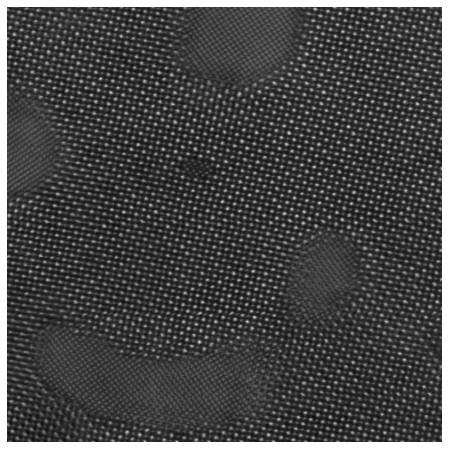

In [5]:
imagedata = np.load('NiO_LSMO.npy')

model_path = '/content/saved_models/cubic-best_weights.pt'
material = 'NiO_LSMO'

plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

**Load BiFeO$_3$ Data**

[1] Ziatdinov, M. *et al.*, *Applied Physics Reviews* **8**, 011403, doi: 10.1063/5.0016792 (2021)

[2] Nelson, C.T. *et al.*, *Nat. Commun*, **11**, 6361, doi: 10.1038/s41467-020-19907-2 (2020)

[3] Nelson, C.T. *et al.*, (Zenodo, Nature Communications, 2020)

(-0.5, 2047.5, 2047.5, -0.5)

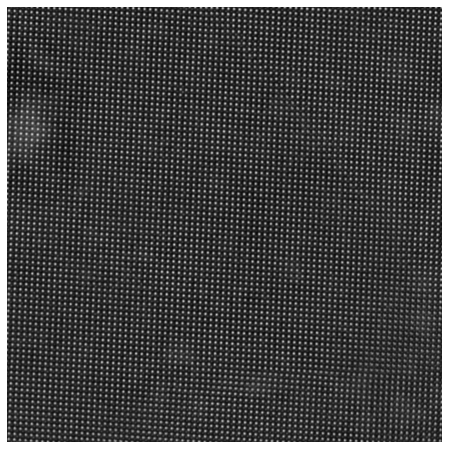

In [ ]:
imagedata = np.load('BFO.npy')

model_path = '/content/saved_models/cubic-best_weights.pt'
material = 'BFO'

plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

**Load Graphene Data**

[1] Ghosh, A. *et al.*, *arXiv*, arXiv:2101.08449v08442 (2021)

[2] Kalinin, S.V. *et al.*, *arXiv*, arXiv:2010.09196v09192 (2021)

Downloading...
From: https://drive.google.com/uc?id=18PQs7M_fBp4Lf0JVQlORERmBmYRJ88-M
To: /content/G_MD.tar
11.1MB [00:00, 67.8MB/s]


(-0.5, 1023.5, 1023.5, -0.5)

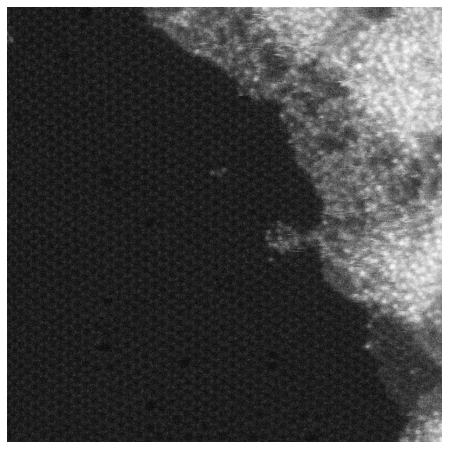

In [43]:
imagedata = np.load('Si-Graphene.npy')

!gdown "https://drive.google.com/uc?id=18PQs7M_fBp4Lf0JVQlORERmBmYRJ88-M"
model_path = 'G_MD.tar'
material = 'Gr'

plt.figure(figsize=(8,8))
plt.imshow(imagedata,cmap='gray')
plt.axis('off')

# Image Segmentation

Perform image segmantation via deep convolutional neural network (DCNN).  

Batch 1/1
1 image was decoded in approximately 6.3202 seconds


Text(0.5, 1.0, 'Coordinates')

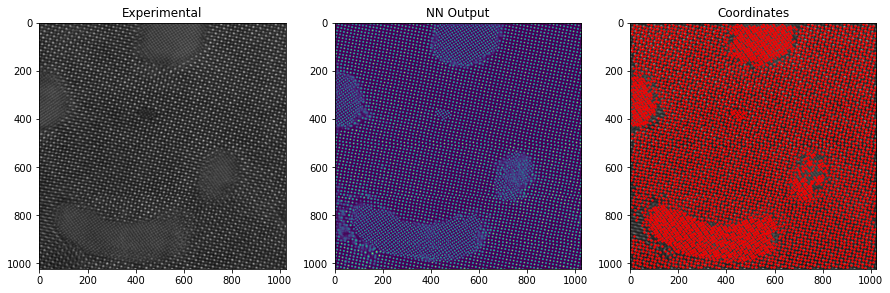

In [7]:
if '.pt' in model_path: 
  weights_path = model_path  
  model_skel = resatomsegnet_s2()
  model = aoi.utils.load_weights(model_skel, weights_path)
  predictor = aoi.predictors.SegPredictor(model, logits=False)  # logits=False if your NN ends with sigmoid/softmax

if '.tar' in model_path:
  model = aoi.load_model(model_path)
  predictor = aoi.predictors.SegPredictor(model.net, logits=True)  # logits=False if your NN ends with sigmoid/softmax

nn_output, coords = predictor.run(imagedata)
coord = coords[0][:,:2]
fig,ax = plt.subplots(ncols=3,figsize=(15,10))
ax[0].imshow(imagedata,cmap='gray')
ax[0].set_title('Experimental')
ax[1].imshow(nn_output[0,:,:,0]*255)
ax[1].set_title('NN Output')
ax[2].imshow(imagedata,cmap='gray')
ax[2].scatter(coord[:,1],coord[:,0],c='r',s=2)
ax[2].set_title('Coordinates')

Next, create stack of subimages, each centered on an atom.

Stack:  (5044, 64, 64, 1)


Text(0.5, 1.0, 'sub-image')

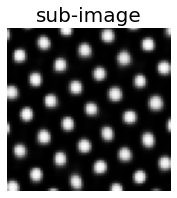

In [15]:
window_size=64
stack, com, frames = aoi.utils.extract_subimages(nn_output, coords, window_size=window_size, coord_class=0)
print('Stack: ', stack.shape) 
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax1.imshow(stack[200,...,0], cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('sub-image', fontsize=20)

# Dimensionality Reduction

Next, perform dimensionality reduction and find latent variables using a rotationaly invariant autoencoder (rVAE).

[1] Kalinin, S.V. *et al.*, *Science Advances*, eabd5084 (2021). doi:10.1126/sciadv.abd5084




In [16]:
#torch.set_default_tensor_type(torch.FloatTensor) 
input_dim = (window_size, window_size)
rvae = aoi.models.rVAE(input_dim)
rvae.fit(stack.reshape(stack.shape[:-1]),training_cycles=200,batch_size=64)

Epoch: 1/200, Training loss: 174.4668
Epoch: 2/200, Training loss: 169.0768
Epoch: 3/200, Training loss: 168.8100
Epoch: 4/200, Training loss: 168.7274
Epoch: 5/200, Training loss: 168.6170
Epoch: 6/200, Training loss: 168.6012
Epoch: 7/200, Training loss: 168.6471
Epoch: 8/200, Training loss: 168.4556
Epoch: 9/200, Training loss: 168.4875
Epoch: 10/200, Training loss: 168.6108
Epoch: 11/200, Training loss: 168.4371
Epoch: 12/200, Training loss: 168.3660
Epoch: 13/200, Training loss: 168.3735
Epoch: 14/200, Training loss: 168.3818
Epoch: 15/200, Training loss: 168.3921
Epoch: 16/200, Training loss: 168.4400
Epoch: 17/200, Training loss: 168.3406
Epoch: 18/200, Training loss: 168.3021
Epoch: 19/200, Training loss: 168.3693
Epoch: 20/200, Training loss: 168.4008
Epoch: 21/200, Training loss: 168.3553
Epoch: 22/200, Training loss: 168.3683
Epoch: 23/200, Training loss: 168.3687
Epoch: 24/200, Training loss: 168.3357
Epoch: 25/200, Training loss: 168.3894
Epoch: 26/200, Training loss: 168.

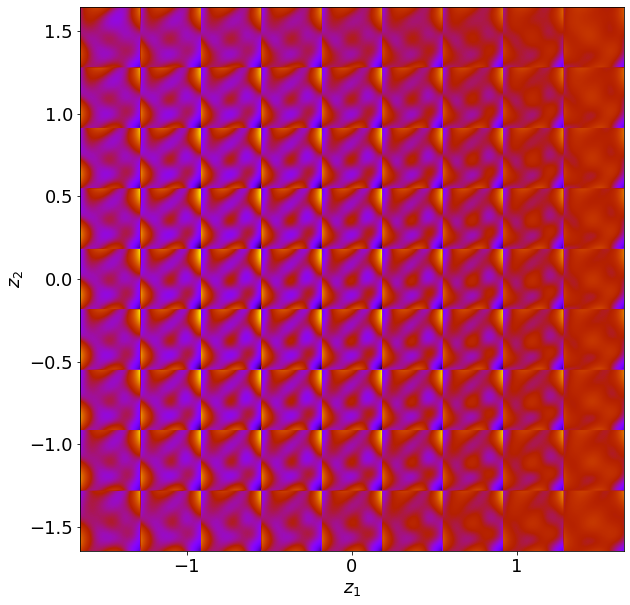

array([[0.18706401, 0.18079042, 0.17481157, ..., 0.09604725, 0.09166315,
        0.08729639],
       [0.19216493, 0.1857013 , 0.17950235, ..., 0.09961361, 0.09539256,
        0.09117067],
       [0.19693586, 0.19031335, 0.18392576, ..., 0.10343069, 0.09936118,
        0.09527083],
       ...,
       [0.13290042, 0.13843192, 0.14366134, ..., 0.19092722, 0.19668679,
        0.20268439],
       [0.13268074, 0.13840862, 0.14384434, ..., 0.19023035, 0.19608158,
        0.2021938 ],
       [0.13249719, 0.13842453, 0.14406911, ..., 0.18929206, 0.19522333,
        0.20143792]])

In [17]:
rvae.manifold2d()

View latent variable distributions

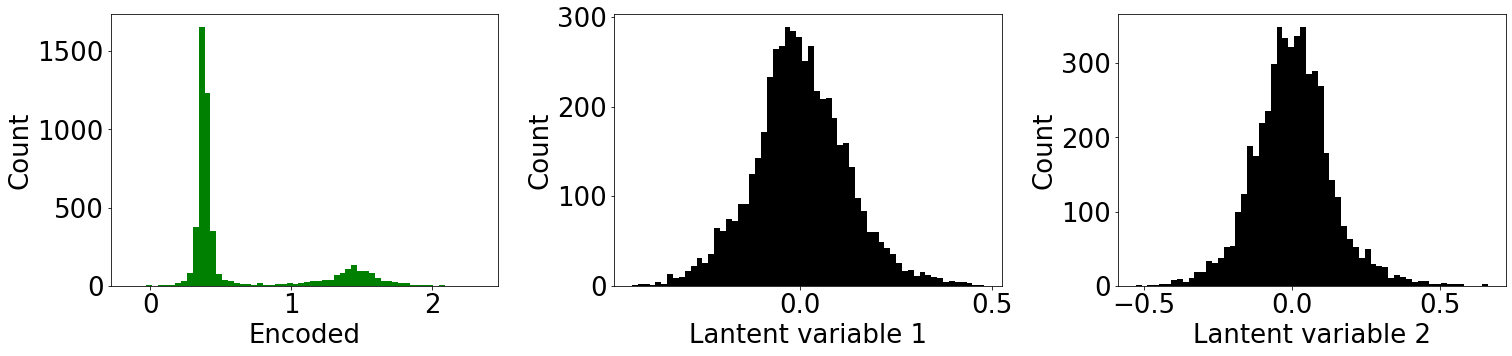

In [18]:
z_mean, z_sd = rvae.encode(stack)
z1, z2 , z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

plt.rcParams.update({'font.size':26})
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='green')
ax[1].hist(z2[:, 0], bins=60, color='k')
ax[2].hist(z2[:, 1], bins=60, color='k')
ax[0].set_xlabel("Encoded")
ax[1].set_xlabel("Lantent variable 1") #X-offset for rVAE, L1 for rrVAE
ax[2].set_xlabel("Lantent variable 2") #Y-offset for rVAE, L2 for rrVAE
for _ax in fig.axes:
    _ax.set_ylabel("Count")
    # _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

View spatial location of latent variables

In [19]:
xs = np.arange(0,int(len(stack)**0.5))
ys = np.arange(0,int(len(stack)**0.5))
xv, yv = np.meshgrid(xs, ys)

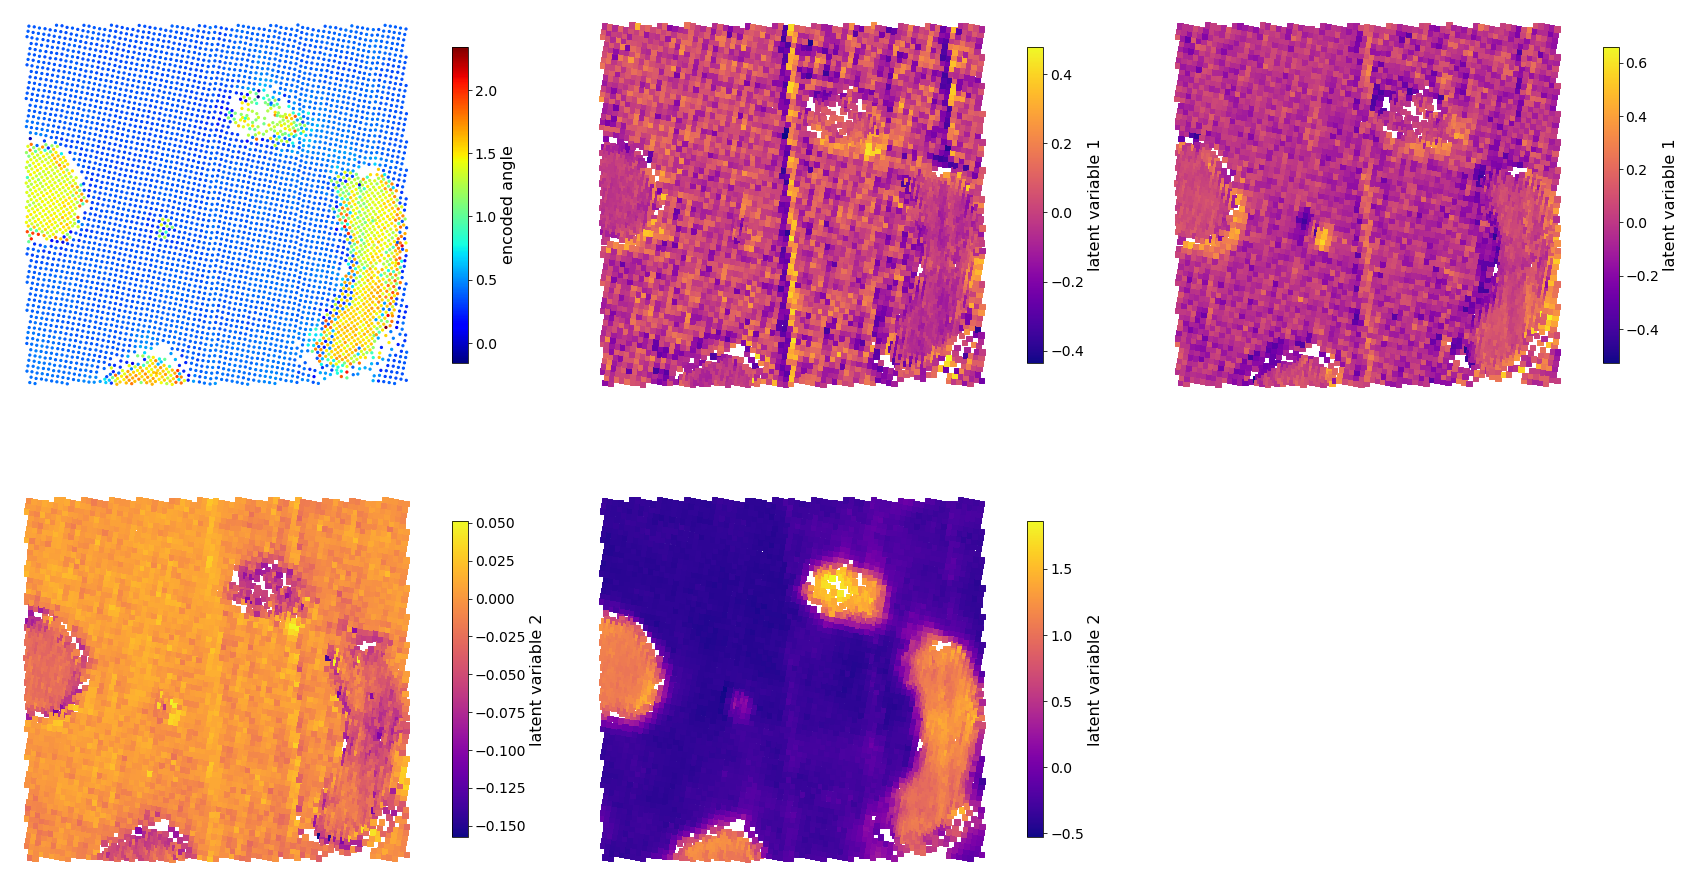

In [20]:
frame = 0 # select frame
work_image = imagedata[frame]
com_i = com[np.where(frames == frame)] # get coordinates for this frame
z1_i = z1[np.where(frames == frame)] # get latent variables (image) for this frame
z2_i = z2[np.where(frames == frame)] # get latent variables (image) for this frame
z3_i = z3[np.where(frames == frame)] # get latent variables (image) for this frame


fig, axes = plt.subplots(nrows=2, ncols=3, figsize = (30,16))
fig.subplots_adjust(wspace=0.1)

im1 = axes[0,0].scatter(com_i[:,0], com_i[:,1], c = z1_i, s=5, cmap="jet")
cbar1 = fig.colorbar(im1, ax=axes[0,0], shrink=.8)
cbar1.set_label("encoded angle", fontsize=16)
cbar1.ax.tick_params(labelsize=14)
axes[0,0].axis('off')

im2 = axes[0,1].scatter(com_i[:,0], com_i[:,1], c = z2_i[:,0], s=30,marker='s', cmap="plasma")
cbar2 = fig.colorbar(im2, ax=axes[0,1], shrink=.8)
cbar2.set_label("latent variable 1", fontsize=16)
cbar2.ax.tick_params(labelsize=14)
axes[0,1].axis('off')

im3 = axes[0,2].scatter(com_i[:,0], com_i[:,1], c = z2_i[:,1], s=30,marker='s', cmap="plasma")
cbar3 = fig.colorbar(im3, ax=axes[0,2], shrink=.8)
cbar3.set_label("latent variable 1", fontsize=16)
cbar3.ax.tick_params(labelsize=14)
axes[0,2].axis('off')

im3 = axes[1,0].scatter(com_i[:,0], com_i[:,1], c = z3_i[:,0], s=30,marker='s', cmap="plasma")
cbar3 = fig.colorbar(im3, ax=axes[1,0], shrink=.8)
cbar3.set_label("latent variable 2", fontsize=16)
cbar3.ax.tick_params(labelsize=14)
axes[1,0].axis('off')

im3 = axes[1,1].scatter(com_i[:,0], com_i[:,1], c = z3_i[:,1], s=30,marker='s', cmap="plasma")
cbar3 = fig.colorbar(im3, ax=axes[1,1], shrink=.8)
cbar3.set_label("latent variable 2", fontsize=16)
cbar3.ax.tick_params(labelsize=14)
axes[1,1].axis('off')

axes[1,2].axis('off')

plt.show()

Choose the component which will be the variable of interest.  

(-0.5, 89.5, 89.5, -0.5)

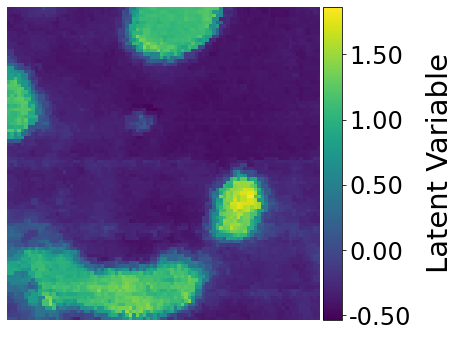

In [21]:
aimg0 = z3_i[:,1]

xi = np.linspace(com_i[:,1].min(), com_i[:,1].max(), 90)
yi = np.linspace(com_i[:,0].min(), com_i[:,0].max(), 90)
xi, yi = np.meshgrid(xi, yi)
from scipy.interpolate import griddata
aimg = griddata(com_i, aimg0, (yi, xi), method='nearest')

if material == 'Gr':
  grid_z1 = griddata(com_i, aimg0, (xi, yi), method='linear')
  mask = np.isfinite(grid_z1)
  aimg = (mask*grid_z1).T


fig,ax=plt.subplots(figsize=(6,6))
im=ax.imshow(aimg)
k=int(len(aimg)**0.5)
divider = make_axes_locatable(ax)
# Append axes to the right of ax3, with 10% width of ax
cax = divider.append_axes("right", size="6%", pad=0.05)

cbar=plt.colorbar(im, cax = cax, format="%.2f")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Latent Variable',fontsize=29)
cbar.ax.tick_params(labelsize=24) 

ax.axis('off')

#Prepare Data for Simulated Data Collection

Here we are going to prepare a blank data set, removing all but 1 data point from our chosen abundance map.

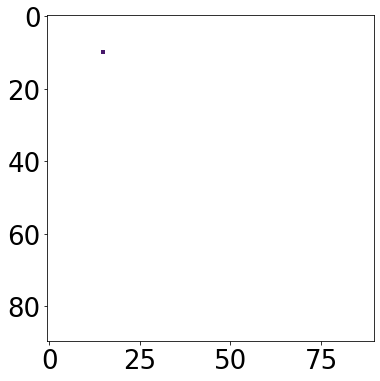

In [22]:
blank_data = np.empty(aimg.shape)
blank_data[:] = np.nan

seed = [(10,15)] # location in pixels, feel free to change or add more
for ii in range(len(seed)):
  blank_data[seed[ii]] = aimg[seed[ii]]

plt.figure(figsize=(6,6))
plt.imshow(blank_data,vmin = np.min(aimg),vmax=np.max(aimg))

Set up Bayesian Optimization for predicting next point.

In [23]:
Z_sparse = blank_data
X_sparse = gpim.utils.get_sparse_grid(Z_sparse)
X_full = gpim.utils.get_full_grid(Z_sparse)
idx = seed
points_measured = [xy_to_pixind(x,y, num_cols=28) for (x,y) in idx]
mask = get_mask(Z_sparse, points_measured)

# Bayesian Optimization

In [33]:
lengthscale = [11.,50.]
batch_out_max = 10
kernel = 'Matern52' #'RBF', 'Matern52', 'RationalQuadratic'
batch_size = 500
exploration_steps = 200
gp_iterations = 300
acquisition = 'ei' # acq, 'cb', 'poi', 'ei'


boptim = gpim.boptimizer(
  X_sparse, Z_sparse, X_full,
  trial_func, acquisition_function= acquisition, batch_update = True, lengthscale = lengthscale,
  batch_out_max = batch_out_max,kernel = kernel, mask = mask,
  exploration_steps=exploration_steps,batch_size=batch_size,gp_iterations=gp_iterations,
  use_gpu=True,
  verbose=2)

Run BO

In [34]:
boptim.run() #  Run Bayesian optimization

Streaming output truncated to the last 5000 lines.
Finding the next max point...
Acquisition function max value 5.075943164681585e-10 at [77, 36]
Finding the next max point...
Acquisition function max value 5.035149926986554e-10 at [78, 38]
Finding the next max point...
Acquisition function max value 4.798779144819017e-10 at [81, 38]
Finding the next max point...
Acquisition function max value 4.708611657989637e-10 at [10, 44]
Finding the next max point...
Acquisition function max value 4.629229499067668e-10 at [80, 49]
Finding the next max point...
Acquisition function max value 4.4116459890654827e-10 at [83, 50]
Finding the next max point...
Acquisition function max value 4.251941758549217e-10 at [7, 39]
Finding the next max point...
Acquisition function max value 4.212206830573973e-10 at [9, 42]
Finding the next max point...
Acquisition function max value 3.9594362924113667e-10 at [77, 50]
Finding the next max point...
Acquisition function max value 3.9172723713196584e-10 at [64, 68

View Results

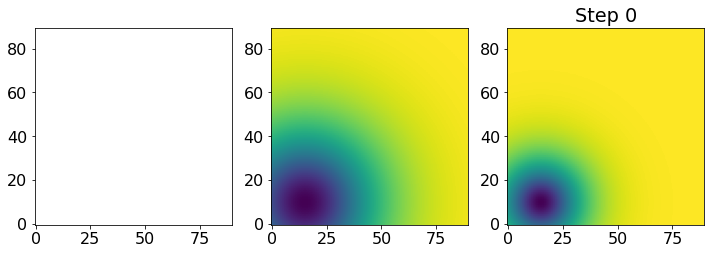

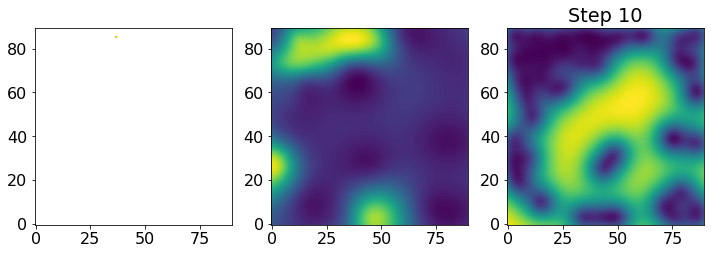

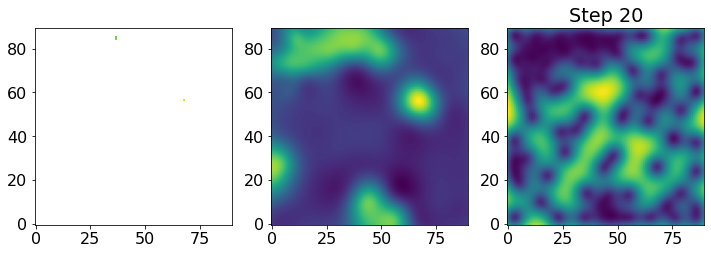

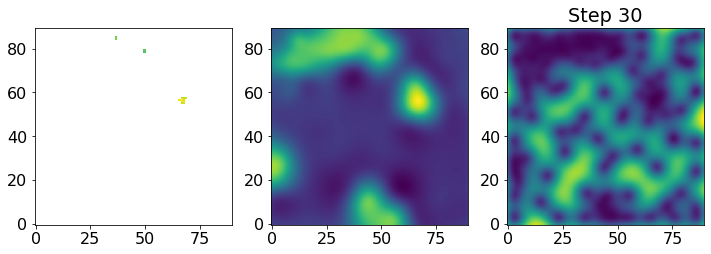

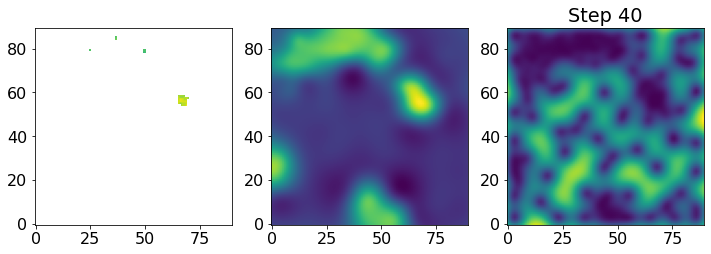

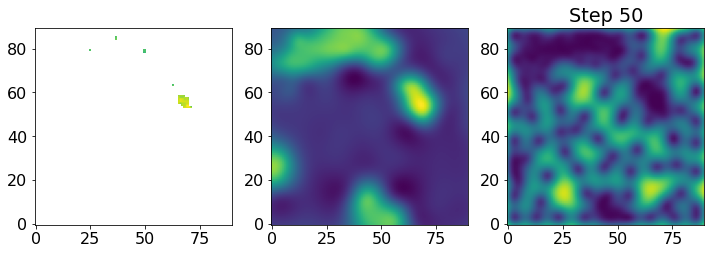

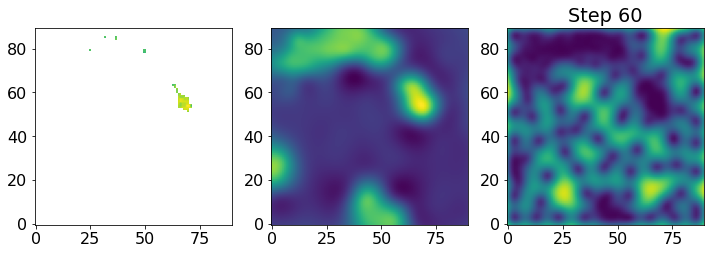

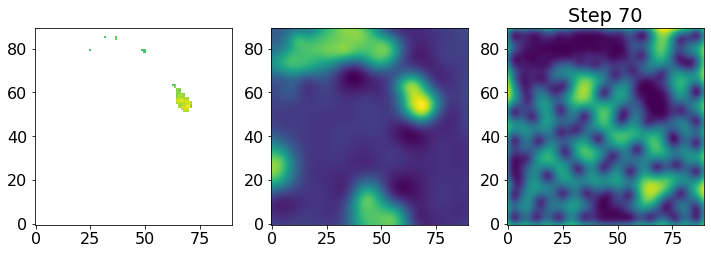

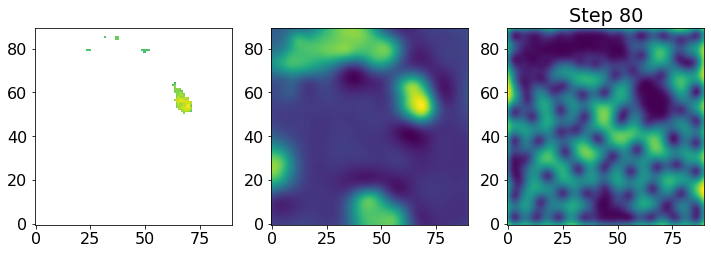

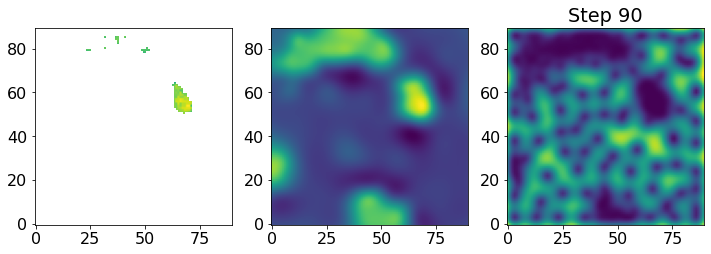

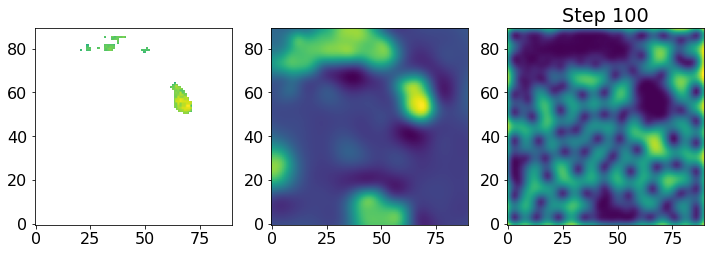

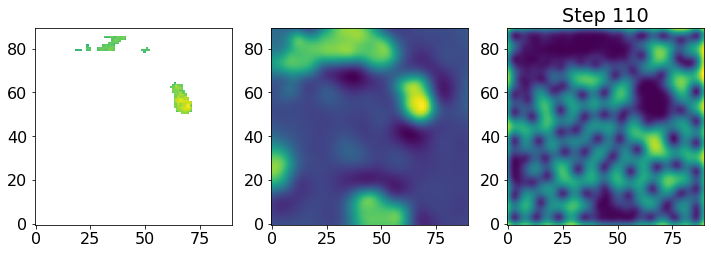

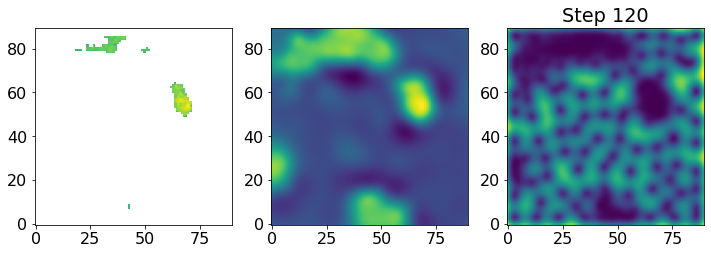

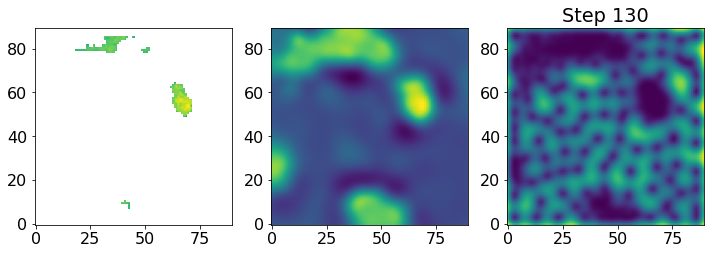

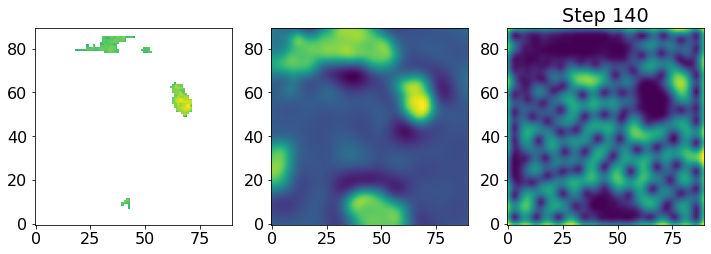

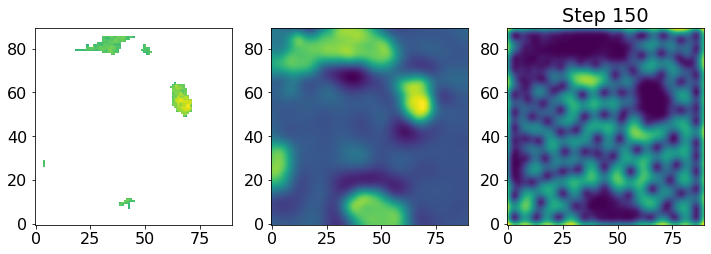

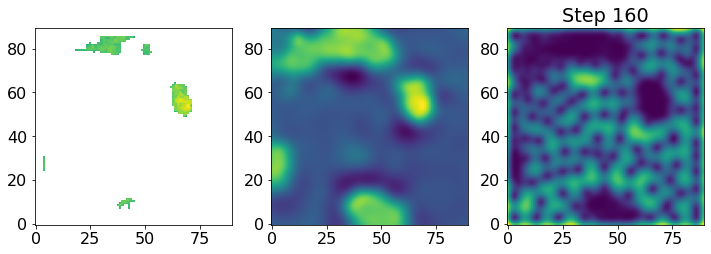

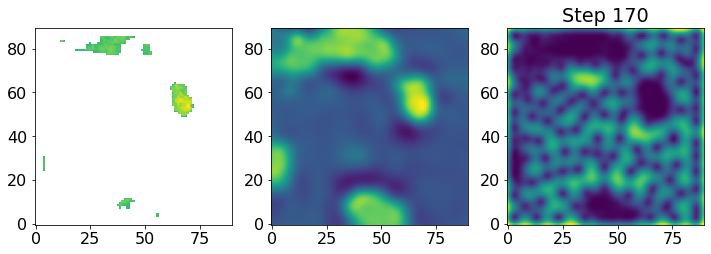

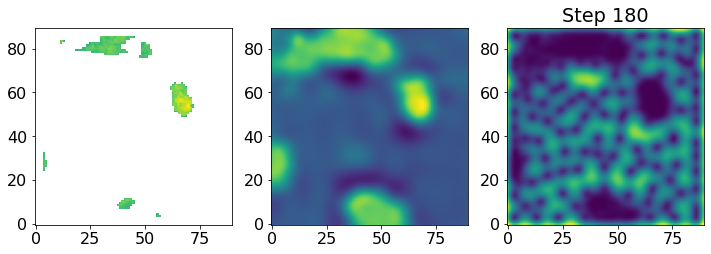

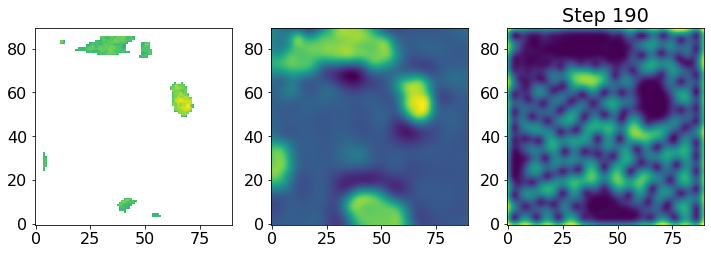

In [35]:
func_val, gp_pred = boptim.target_func_vals, boptim.gp_predictions
for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
    if i%10 == 0:
      _, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
      ax1.imshow(func, origin='bottom')
      ax2.imshow(pred[0], origin='bottom')
      ax3.imshow(pred[1], origin='bottom')
      plt.title('Step {}'.format(i))
      plt.show()
    else:
      continue

# Quantify Results

##Image Reconstruction

Calculate the accuracy of reproducing the full data given the sparse dataset using a structural similarity index measure (SSIM).

In [36]:
from skimage.metrics import structural_similarity as ssim
comp = []
avg_unc = []
for i, (func, pred) in enumerate(zip(func_val, gp_pred)):
  comp.append(ssim(aimg,pred[0],data_range=aimg[0].max()-aimg[0].min()))

  avg_unc.append(np.mean(pred[1]))

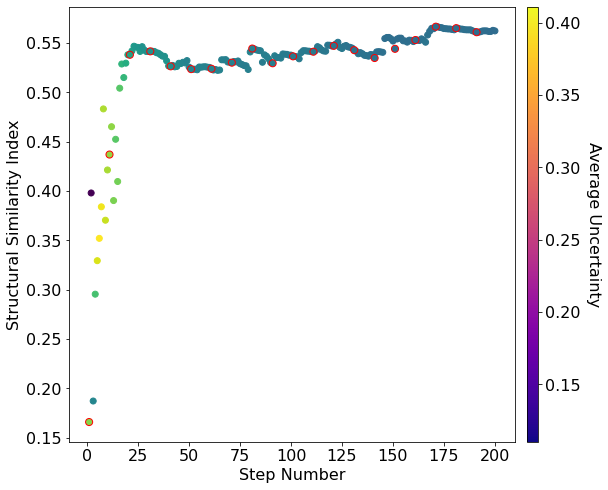

In [37]:
plt.rcParams.update({'font.size': 16})

fig,ax = plt.subplots(figsize=(8,8))
cbaxs = fig.add_axes([0.92,0.125,0.02,0.755])

ax.scatter(np.arange(1,exploration_steps+1),comp,c=avg_unc)
ax.set_ylabel('Structural Similarity Index')
ax.set_xlabel('Step Number')

scbar = plt.cm.ScalarMappable(cmap=plt.cm.plasma,norm=plt.Normalize(vmin=np.asarray(avg_unc).min(),vmax=np.asarray(avg_unc).max()))

scbar._A=[]
cbar = plt.colorbar(scbar,cax=cbaxs)
cbar.ax.set_ylabel('Average Uncertainty',rotation=270,labelpad=20)

sub_10 = [comp[x] for x in range(len(comp)) if x%10==0]
ax.scatter(np.arange(1,exploration_steps+1,10),sub_10,s=50,facecolors='none', edgecolors='r')

##BO Efficiency

Here we will quantify the efficiency of the BO by calculating the percentage of region of interest we were able to locate. 

Text(0, 0.5, 'Percentage of Feature of Interest Collected')

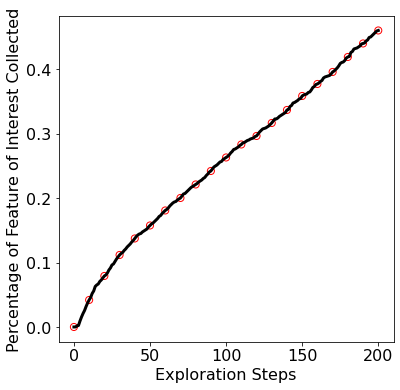

In [38]:
sigma2 = np.std(np.ravel(aimg))**2
bw = np.where(aimg>sigma2,1,0)
locs0=np.argwhere(bw>0)
locs = [ list(item) for item in locs0 ]
locs = [x for x in locs if x[0]>3 and x[0]<aimg.shape[0]-3 and x[1]>3 and x[1]< aimg.shape[1]-3]
counter = []
for ii in range(len(func_val)):
  locs_bo=np.argwhere(~np.isnan(func_val[ii]))
  counter.append(np.sum([1 for x in locs_bo if list(x) in locs]))

fig,ax=plt.subplots(figsize=(6,6))
ax.plot(np.asarray(counter)/len(locs),'k',linewidth=3)
sub_10 = [counter[x]/len(locs) for x in range(exploration_steps+1) if x%10==0]
ax.scatter(np.arange(0,exploration_steps+1,10),sub_10,s=50,facecolors='None', edgecolors='r')
ax.set_xlabel('Exploration Steps')
ax.set_ylabel('Percentage of Feature of Interest Collected')